<a href="https://colab.research.google.com/github/spegas/Dacon/blob/main/stock_mlp_up_down.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy pandas matplotlib scikit-learn tensorflow yfinance

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, date
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [ ]:
# 주식 데이터 가져오기
ticker = '005930.KS'  # 삼성전자 종목코드 예시

In [ ]:
end_date = datetime.today()
str_end_date = end_date.strftime('%Y-%m-%d')
print(" -- str_end_date -- ")
print(str_end_date)

start_date = end_date - timedelta(days=1000)

str_start_date = start_date.strftime('%Y-%m-%d')
print(" -- str_start_date -- ")
print(str_start_date)

 -- str_end_date -- 
2024-05-23
 -- str_start_date -- 
2021-08-27


In [ ]:
from copy import deepcopy
fetch_stock_data = yf.download(ticker, start=str_start_date, end=str_end_date)
print(fetch_stock_data.columns)
print(fetch_stock_data.head(5))
# stock_data = fetch_stock_data[['Close', 'Volume']]

stock_data = fetch_stock_data.copy(deep=True).drop(columns=['Adj Close'])

[*********************100%%**********************]  1 of 1 completed

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
               Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2021-08-27  74300.0  75000.0  73800.0  74300.0  70375.070312  15172748
2021-08-30  75400.0  75500.0  74200.0  74600.0  70659.210938  12686999
2021-08-31  74900.0  76700.0  74300.0  76700.0  72648.281250  24630370
2021-09-01  76700.0  77100.0  75900.0  76800.0  72743.015625  16114775
2021-09-02  76800.0  76800.0  75700.0  76000.0  71985.265625  15347486


In [ ]:
# 추가 데이터 (유사 종목 및 회사 회계정보)
# 유사 종목 데이터 예시
similar_ticker = '000660.KS'  # SK하이닉스 종목코드 예시

In [ ]:
from types import new_class
fetch_similar_data = yf.download(similar_ticker, start=str_start_date, end=str_end_date)
# stock_data['Similar_Close'] = fetch_similar_data['Close']

similar_stock_data = fetch_similar_data.copy(deep=True).drop(columns=['Adj Close'])

new_columns = [str("S_") + str(column) for column in similar_stock_data.columns]

similar_stock_data.columns = new_columns

[*********************100%%**********************]  1 of 1 completed


In [ ]:
total_stock_data = pd.concat([stock_data, similar_stock_data], axis=1)

In [ ]:
# 회사 회계 정보 예시 (여기서는 임의의 데이터 사용)
# 실제로는 회사의 분기별 또는 연간 재무제표 데이터를 사용
financial_data = {
    'Date': stock_data.index,
    'Revenue': np.random.uniform(100, 500, len(stock_data)),
    'Operating_Income': np.random.uniform(10, 50, len(stock_data))
}

In [ ]:
# financial_df = pd.DataFrame(financial_data)
# financial_df.set_index('Date', inplace=True)

# # 주식 데이터와 재무 데이터 병합
# ml_input_data = pd.concat([total_stock_data, financial_df], axis=1)
ml_input_data = total_stock_data.copy()

In [ ]:
print(ml_input_data.head(10))

               Open     High      Low    Close    Volume    S_Open    S_High  \
Date                                                                           
2021-08-27  74300.0  75000.0  73800.0  74300.0  15172748  103500.0  104500.0   
2021-08-30  75400.0  75500.0  74200.0  74600.0  12686999  105000.0  105500.0   
2021-08-31  74900.0  76700.0  74300.0  76700.0  24630370  103500.0  106500.0   
2021-09-01  76700.0  77100.0  75900.0  76800.0  16114775  106000.0  108000.0   
2021-09-02  76800.0  76800.0  75700.0  76000.0  15347486  108000.0  108500.0   
2021-09-03  76400.0  76700.0  76000.0  76600.0  12096419  106500.0  107500.0   
2021-09-06  76800.0  77600.0  76600.0  77300.0  12861180  106500.0  107000.0   
2021-09-07  77100.0  77100.0  75900.0  76100.0  13239401  105500.0  106000.0   
2021-09-08  76000.0  76400.0  75600.0  76300.0  11798147  104000.0  107500.0   
2021-09-09  76400.0  76600.0  75000.0  75300.0  17600770  105000.0  106000.0   

               S_Low   S_Close  S_Volum

In [ ]:
# 목표 변수 생성
ml_input_data['Target'] = np.where(ml_input_data['Close'].shift(-1) > ml_input_data['Close'], 'U', 'D')
ml_input_data = ml_input_data.dropna()

In [ ]:
# 입력 변수와 목표 변수 분리
X = ml_input_data.drop(columns=['Target'])
y = ml_input_data['Target']

In [ ]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

In [ ]:
# 라벨 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, shuffle=False)

In [ ]:
# 데이터셋 생성 함수
def create_dataset(data, labels, look_back=20):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)].flatten())
        Y.append(labels[i + look_back])
    return np.array(X), np.array(Y)

In [ ]:
# look_back -> LSTM 학습에 사용되는 날짜, 30일이면 약 한달치 데이터를 학해해서 그 다음날꺼 예측 하는 것임
# 만약, 이시간을 길게하면 X_test, Y_test데이터가 안 만들어 질 수 있고
# 이를 극복하기 위해서 yahoo에서 주식 데이터 수집 날짜 간격을 늘리거나, 학습에 사용되는 날짜 즉, time_step를 짧게 하면 됨.
look_back = 20

# my_epochs는 학습을 몇번 반복 할것인가를 의미하는 것임,
my_epochs=5

In [ ]:
X_train, y_train = create_dataset(X_train, y_train, look_back)
X_test, y_test = create_dataset(X_test, y_test, look_back)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(515, 200) (515,)
(114, 200) (114,)


In [ ]:
# LSTM 모델 정의 및 학습

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # 이진 분류를 위한 sigmoid 활성화 함수

# 옵티마이저 설정 (학습률 변경)
my_optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=my_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=1, epochs=my_epochs)

Epoch 1/5
515/515 [==============================] - 2s 2ms/step - loss: 0.6940 - accuracy: 0.5592
Epoch 2/5
515/515 [==============================] - 1s 2ms/step - loss: 0.6860 - accuracy: 0.5573
Epoch 3/5
515/515 [==============================] - 1s 3ms/step - loss: 0.6864 - accuracy: 0.5728
Epoch 4/5
515/515 [==============================] - 1s 2ms/step - loss: 0.6817 - accuracy: 0.5786
Epoch 5/5
515/515 [==============================] - 1s 2ms/step - loss: 0.6833 - accuracy: 0.5728


In [ ]:
# 테스트 데이터 예측
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int)  # 0.5를 기준으로 클래스를 결정

# 예측 결과를 'U'와 'D'로 변환
predicted_labels = label_encoder.inverse_transform(predictions.flatten())

# 실제값과 예측값 시각화
actual_labels = label_encoder.inverse_transform(y_test)

results = pd.DataFrame({'Date': ml_input_data.index[-len(actual_labels):], 'Actual': actual_labels, 'Predicted': predicted_labels})

print(results.head(20))

4/4 [==============================] - 0s 4ms/step
         Date Actual Predicted
0  2023-12-01      U         D
1  2023-12-04      D         D
2  2023-12-05      U         D
3  2023-12-06      D         D
4  2023-12-07      U         D
5  2023-12-08      U         D
6  2023-12-11      U         D
7  2023-12-12      D         D
8  2023-12-13      U         D
9  2023-12-14      U         D
10 2023-12-15      D         D
11 2023-12-18      U         D
12 2023-12-19      U         D
13 2023-12-20      U         D
14 2023-12-21      U         D
15 2023-12-22      U         D
16 2023-12-26      U         D
17 2023-12-27      U         D
18 2023-12-28      U         D
19 2024-01-02      D         D


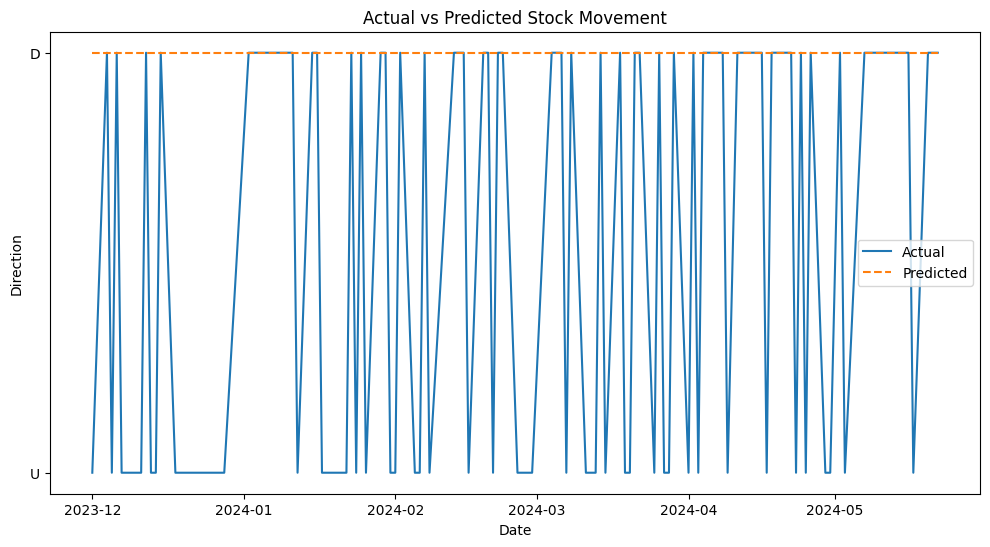

In [ ]:
# 실제값과 예측값을 시각화
plt.figure(figsize=(12, 6))
plt.plot(results['Date'], results['Actual'], label='Actual')
plt.plot(results['Date'], results['Predicted'], label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Direction')
plt.title('Actual vs Predicted Stock Movement')
plt.legend()
plt.show()